In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim


C:\Users\ADMIN\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
 
# Run in terminal or command prompt
#python3 -m spacy download en

 
from pprint import pprint


from sklearn.cluster import KMeans

from sklearn.decomposition import TruncatedSVD

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

 
# Plotting tools
#import pyLDAvis
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])



In [4]:
#fp = '/Users/sourish/Documents/Research/Kalapakkam/Manjula/Topic_Model/pubnew.csv'
fp = "F:datasets/pubnew.csv"
df = pd.read_csv(fp)
df.head()


,content
0,Matrix rank based ontology matching: An extens...
1,Sputtered AZO Thin Films for TCO and Back Refl...
2,Assessment of natural radioactivity and radiol...
3,Accelerated rusting of reinforcing bars: The r...
4,Comparison of phase interaction models for hig...


In [5]:
 # Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]


# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]


# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


pprint(data[:1])

['Matrix rank based ontology matching: An extension of string equality '
 'matchingIn this article, a string-based algorithm and the analogy of the '
 'total number of deviations that exist between two matrices are used for '
 'ontology matching. The type of matching and the distance between them are '
 'derived from the rank of the matrix. This process is useful for an agent '
 'programme to extract the knowledge from the application domain and to '
 'evaluate the result of matching to decide whether to include or exclude the '
 'ontology. As a case study to demonstrate the developed algorithm, the Fast '
 'Breeder Test Reactor (FBTR) is taken for analysis by representing its '
 'components, such as the steam generator system and the control rod drive '
 'mechanism, in formats such as RDF (Resource Description Framework) and OWL '
 '(Web Ontology Language).']


In [6]:

'''Tokenize words and Clean-up text'''

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))

print(data_words[:1])


[['matrix', 'rank', 'based', 'ontology', 'matching', 'an', 'extension', 'of', 'string', 'equality', 'matchingin', 'this', 'article', 'string', 'based', 'algorithm', 'and', 'the', 'analogy', 'of', 'the', 'total', 'number', 'of', 'deviations', 'that', 'exist', 'between', 'two', 'matrices', 'are', 'used', 'for', 'ontology', 'matching', 'the', 'type', 'of', 'matching', 'and', 'the', 'distance', 'between', 'them', 'are', 'derived', 'from', 'the', 'rank', 'of', 'the', 'matrix', 'this', 'process', 'is', 'useful', 'for', 'an', 'agent', 'programme', 'to', 'extract', 'the', 'knowledge', 'from', 'the', 'application', 'domain', 'and', 'to', 'evaluate', 'the', 'result', 'of', 'matching', 'to', 'decide', 'whether', 'to', 'include', 'or', 'exclude', 'the', 'ontology', 'as', 'case', 'study', 'to', 'demonstrate', 'the', 'developed', 'algorithm', 'the', 'fast', 'breeder', 'test', 'reactor', 'fbtr', 'is', 'taken', 'for', 'analysis', 'by', 'representing', 'its', 'components', 'such', 'as', 'the', 'steam',

In [7]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  


C:\Users\ADMIN\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [8]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['matrix', 'rank', 'based', 'ontology', 'matching', 'an', 'extension', 'of', 'string', 'equality', 'matchingin', 'this', 'article', 'string', 'based', 'algorithm', 'and', 'the', 'analogy', 'of', 'the', 'total', 'number', 'of', 'deviations', 'that', 'exist', 'between', 'two', 'matrices', 'are', 'used', 'for', 'ontology', 'matching', 'the', 'type', 'of', 'matching', 'and', 'the', 'distance', 'between', 'them', 'are', 'derived', 'from', 'the', 'rank', 'of', 'the', 'matrix', 'this', 'process', 'is', 'useful', 'for', 'an', 'agent', 'programme', 'to', 'extract', 'the', 'knowledge', 'from', 'the', 'application', 'domain', 'and', 'to', 'evaluate', 'the', 'result', 'of', 'matching', 'to', 'decide', 'whether', 'to', 'include', 'or', 'exclude', 'the', 'ontology', 'as', 'case', 'study', 'to', 'demonstrate', 'the', 'developed', 'algorithm', 'the', 'fast_breeder_test', 'reactor_fbtr', 'is', 'taken', 'for', 'analysis', 'by', 'representing', 'its', 'components', 'such', 'as', 'the', 'steam', 'generato

In [9]:
'''Remove Stopwords, Make Bigrams and Lemmatize'''

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [34]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)


# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
#nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)


In [35]:
# Create Corpus
#texts = data_words_bigrams
texts = data_lemmatized

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in texts]


In [36]:
# View
print(corpus[:1])

id2word[0]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 2), (34, 1), (35, 3), (36, 1), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)]]


[[('agent', 1),
  ('algorithm', 2),
  ('analogy', 1),
  ('analysis', 1),
  ('application', 1),
  ('article', 1),
  ('base', 2),
  ('case', 1),
  ('component', 1),
  ('control', 1),
  ('decide', 1),
  ('demonstrate', 1),
  ('derive', 1),
  ('description', 1),
  ('develop', 1),
  ('deviation', 1),
  ('distance', 1),
  ('domain', 1),
  ('drive', 1),
  ('equality', 1),
  ('evaluate', 1),
  ('exclude', 1),
  ('exist', 1),
  ('extension', 1),
  ('extract', 1),
  ('fast_breeder', 1),
  ('format', 1),
  ('framework', 1),
  ('generator', 1),
  ('include', 1),
  ('knowledge', 1),
  ('language', 1),
  ('match', 2),
  ('matching', 2),
  ('matchingin', 1),
  ('matrix', 3),
  ('mechanism', 1),
  ('number', 1),
  ('ontology', 4),
  ('owl', 1),
  ('process', 1),
  ('programme', 1),
  ('rank', 2),
  ('rdf', 1),
  ('represent', 1),
  ('resource', 1),
  ('result', 1),
  ('rod', 1),
  ('steam', 1),
  ('string', 2),
  ('study', 1),
  ('system', 1),
  ('take', 1),
  ('test', 1),
  ('total', 1),
  ('type', 1

In [37]:

''' find the optimal number of topics for LDA'''

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel( corpus=corpus
                                                ,num_topics=num_topics
                                                ,id2word=id2word
                                                ,random_state=100
                                                ,update_every=1
                                                ,chunksize=100
                                                ,passes=10
                                                ,iterations=50000
                                                ,alpha='auto'
                                                ,per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


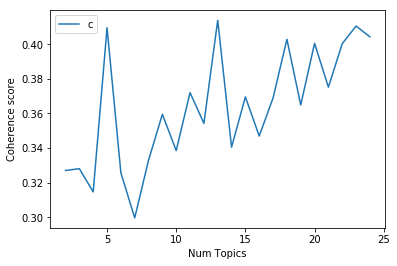

In [38]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word
                                                        , corpus=corpus
                                                        , texts=texts
                                                        , start=2, limit=25, step=1)

# Show graph
limit=25; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.3271
Num Topics = 3  has Coherence Value of 0.3281
Num Topics = 4  has Coherence Value of 0.3147
Num Topics = 5  has Coherence Value of 0.4096
Num Topics = 6  has Coherence Value of 0.3257
Num Topics = 7  has Coherence Value of 0.2997
Num Topics = 8  has Coherence Value of 0.333
Num Topics = 9  has Coherence Value of 0.3595
Num Topics = 10  has Coherence Value of 0.3386
Num Topics = 11  has Coherence Value of 0.3721
Num Topics = 12  has Coherence Value of 0.3543
Num Topics = 13  has Coherence Value of 0.4139
Num Topics = 14  has Coherence Value of 0.3406
Num Topics = 15  has Coherence Value of 0.3696
Num Topics = 16  has Coherence Value of 0.347
Num Topics = 17  has Coherence Value of 0.369
Num Topics = 18  has Coherence Value of 0.4029
Num Topics = 19  has Coherence Value of 0.3649
Num Topics = 20  has Coherence Value of 0.4006
Num Topics = 21  has Coherence Value of 0.3752
Num Topics = 22  has Coherence Value of 0.4003
Num Topics = 23  has Coh

In [17]:
# number of toics with optimal coherence value
num_top = 20
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_top, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           iterations=50000,
                                           alpha='auto',
                                           per_word_topics=True)


In [32]:
## topics prob for each documents
doc = lda_model.get_document_topics(corpus,minimum_probability=0)
#print(doc[1])


n = df.shape[0]

doc_topic_prob = np.zeros((n,num_top))
for i in range(0,n,1):
    for j in range(0,num_top,1):
        doc_topic_prob[i,j]  = doc[i][j][1]
        
# Make the pandas dataframe
#df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

cols = ['prob_topic_' + str(i+1) for i in range(num_top)]
docnames = ['Doc_' + str(j+1) for j in range(len(data))]
doc_topic_prob_df.columns = cols
doc_topic_prob_df.index = docnames

doc_topic_prob_df = pd.DataFrame((doc_topic_prob),columns=cols, index=docnames)
doc_topic_prob_df.head()

[(0, 0.0015327351), (1, 0.0008789654), (2, 0.0016328131), (3, 0.0010667872), (4, 0.946124), (5, 0.0011645064), (6, 0.009527861), (7, 0.0027529318), (8, 0.0008836276), (9, 0.0017879317), (10, 0.0009940019), (11, 0.0028532557), (12, 0.002380588), (13, 0.0014007554), (14, 0.0025543885), (15, 0.0021228006), (16, 0.0018935599), (17, 0.0146801835), (18, 0.0025484418), (19, 0.0012198875)]


,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,prob_topic_7,prob_topic_8,prob_topic_9,prob_topic_10,prob_topic_11,prob_topic_12,prob_topic_13,prob_topic_14,prob_topic_15,prob_topic_16,prob_topic_17,prob_topic_18,prob_topic_19,prob_topic_20
Doc_1,0.001758,0.753383,0.001876,0.001224,0.017613,0.001336,0.008408,0.003312,0.001014,0.002051,0.001140,0.003287,0.002750,0.001606,0.002958,0.002436,0.002170,0.187156,0.003120,0.001399
Doc_2,0.001533,0.000879,0.001633,0.001067,0.946130,0.001165,0.009525,0.002753,0.000884,0.001788,0.000994,0.002853,0.002381,0.001401,0.002554,0.002123,0.001894,0.014680,0.002548,0.001220
Doc_3,0.000903,0.000517,0.000961,0.054635,0.009030,0.000685,0.004724,0.001626,0.000520,0.001051,0.000585,0.001686,0.001408,0.622759,0.012758,0.001252,0.001113,0.281505,0.001560,0.000718
Doc_4,0.005095,0.002923,0.005425,0.003547,0.030820,0.003872,0.019873,0.009109,0.002938,0.005939,0.003305,0.009480,0.007879,0.698253,0.126012,0.007800,0.006393,0.038748,0.008536,0.004056
Doc_5,0.000962,0.000551,0.001023,0.000669,0.024399,0.000730,0.047566,0.001726,0.000554,0.001123,0.000623,0.001805,0.001493,0.864084,0.001610,0.001336,0.001189,0.046152,0.001614,0.000765


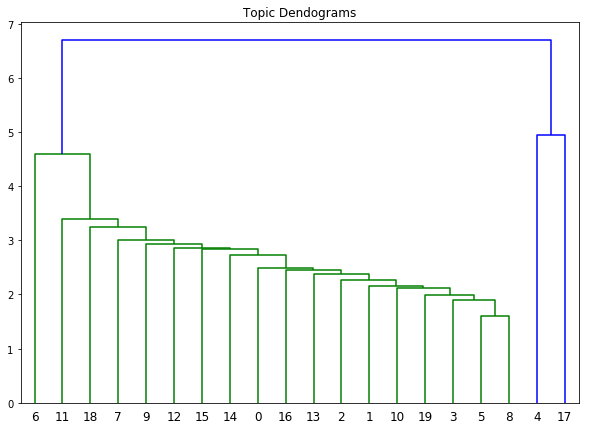

In [33]:
###
doc_topic_prob_df_trans = np.transpose(doc_topic_prob_df)

import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Topic Dendograms")  
dend = shc.dendrogram(shc.linkage(doc_topic_prob_df_trans
                                  , method='ward'),leaf_rotation=0)  


In [22]:
#!/usr/bin/env python2

## top keywords for each topic
lda_model.get_topic_terms(topicid=0)
id2word[159]
id2word[1805]
id2word[1713]
id2word[2334]
""" material, molten, melt, stainless_steel"""






' material, molten, melt, stainless_steel'

In [20]:
lda_model.get_topic_terms(topicid=1)
id2word[1735]
id2word[86]
id2word[90]
id2word[101]
id2word[1905]
""" growth, optical, property, structural, tio """


' growth, optical, property, structural, tio '

In [21]:
lda_model.get_topic_terms(topicid=6)
id2word[266]
id2word[253]
id2word[350]
id2word[1200]
id2word[82]

'grow'